# Project T Final: Collaborative Filtering

CS 189/289A: Introduction to Machine Learning, Fall 2020

Team MA: Maxwell Chen and Abinav Routhu

---

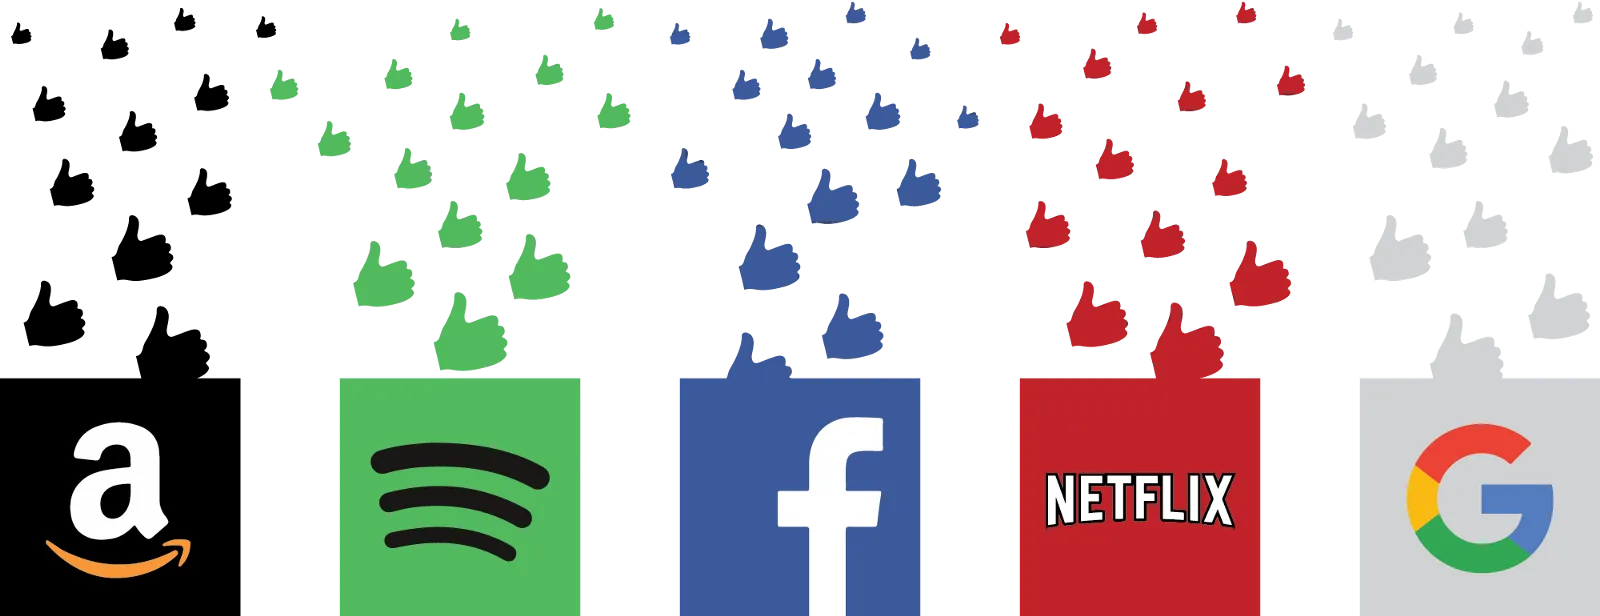

<br>

<center>
    <i>
        (The Data Scientist: What is the right way to build a recommender system for a startup? May 3, 2018)
    </i>
</center>

<hr>

# Introduction

This notebook will cover various methods to construct a recommender system through the process of collaborative filtering -- algorithms and techniques that are concerned with finding similarities between users and items, and calculating numerical ratings to quantify this similarity. We will ground ourself in a standard and accessible application of recommender systems -- recommending movies to users on a service such as Netflix.


# Historical background

The modern age is undergoing rapid and intense changes due to the vast amounts of data being generated in the early 21st century thanks to the Information Age and inventions such as MOSFETs, digital electronics, and the internet. Understanding and leveraging said data has led to the rise of machine learning and data science -- practitioners of these fields are becoming indispensible to virtually every industry. One such "industry" we will focus on in particular is advertising and marketing, which have radically changed through the inception of recommender systems. We see this everywhere -- Amazon products, Spotify songs, Facebook friends, YouTube videos, Google ads -- all these companies are using the concept of learning from data to predict new products to users and customers.

The 2006 Netflix Prize was a $1,000,000 challenge run by Netflix to find the best collaborative filtering algorithm that could improve Netflix movie recommendations. This ran for three years until a team comprised of research scientists bested Netflix's own prediction accuracy by 10.06\%. The contest ignited interest in recommendation and perhaps led to the growth of machine learning competitions through website such as Kaggle.

# Learning Objectives

This notebook serves to introduce and explore the topic of Collaborative Filtering through mathematical methods, along with practical application to the task of recommending movies to users.

Collaborative Filtering is a process or algorithm to filter information or patterns through the collaboration of multiple users, agents, or data sources.

We shall approach this through three paradigms:
1.   Cosine Similarity
2.   Memory-Based Approaches (Clustering, KNN)
3.   Model-Based Approaches (Matrix Factorization)

<hr>

# Table of Contents

```
│───Introduction
│
│───Table of Contents ⭐
│
│───Data Analysis
│   │───Q1: Loading the Dataset
│   └───Q2: Exploratory Data Analysis: Understanding and Visualizing the Dataset
│
│───Q3: The User-Interaction Matrix
│
│───Q4: Cosine Similarity
│
│───Q5: Memory-Based Approaches
│
│───Q6: Model-Based Approaches
│   │───Q5a: Gradient Descent
│   └───Q5b: Stochastic Gradient Descent (SGD)
│
│───Q7: Making your own Predictions
│
└───Extensions (Optional)
    │───Regularization
    └───Surprise Package
```

To-Do:

Q3: Have students implement sklearn functions. Look at training accuracy by using predictions on set

Q6: More setup for GD, and talk about SGD. Lengthen Question. Look at training accuracy by using predictions on set

Q7: Ask the student to make actual predictions
Regularization, Surprise

Latent Space??

In [2]:
# Load Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

To begin, we will load the MovieLens Dataset. MovieLens was a research project launched by GroupLens Research at the University of Minnesota, and was one of the earliest modern projects that investigated personalized recommendations via recommender systems. We will be using their Dataset for a similar purpose: recommending a user which movie to watch based on their own interests or preferences.

<hr>

# Question 1: Loading the Dataset

**1.1:** Import `zipfile` and `from urllib.request import urlretrieve`. Use these libraries to load the [MovieLens Dataset](http://files.grouplens.org/datasets/movielens/ml-100k.zip) -- this is the "small" Dataset containing 100,000 ratings. If you are up for it, you can also load the [expanded MovieLens Dataset](http://files.grouplens.org/datasets/movielens/ml-latest.zip) -- this contains 27,000,000 ratings. For the purposes of this assignment, loading either Dataset will work.

Reference Material:

* [DataCamp Tutorial on zipfile module](https://www.datacamp.com/community/tutorials/zip-file)

* [GeeksForGeeks Tutorial on zipfile module](https://www.geeksforgeeks.org/working-zip-files-python/)

* [urllib.request Documentation](https://docs.python.org/3/library/urllib.request.html)

In [27]:
from urllib.request import urlretrieve
import zipfile
### BEGIN CODE ###
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
### END CODE ###

<hr>

**1.2:** We now have a raw .csv file containing our Dataset. As with many other problems involving machine learning or data mining, we must manipulate our raw data to a form that we can use.

First, investigate the structure of the zipped dataset we just downloaded. Open up each of the unzipped files on DataHub or your local machine, and describe the contents of each file:

<b>Answer:</b>

* `links` contains IDs to identify each movie. Each movie is associated with its ID on IMDB (Internet Movie DataBase) or TMDB (The Movie DataBase).


* `movies` contains IDs to identify each movie. Each entry has a 'title' field containing the name of the movie as well as the year it was released, and a 'genres' field consisting of the different genres the movie falls under, separated by vertical bar characters (the | character).


* `ratings` contains ratings from users on different movies. Each row corresponds to a user with a userID, who rates a movie with a movieID, on a scale from 1 to 5. The timestamp of the rating is also given.


* `tags` contains comments from users on the movies they reviewed/rated. Each row corresponds to a user with userID, a movie with movieID, and a short string containing a 'tag' for that movie. There may be multiple rows for the same user and the same movie, implying there are multiple tags that user assigned to that movie.

<hr>

**1.3:** Use your knowledge of data cleaning and processing from the first week of 16ML to load the different .csv files into multiple Pandas DataFrames. Use the provided columns stored in `user_features`, `ratings_features`, and `movie_features`. Use appropriate naming conventions for these DataFrames, such as "movies", for example. Then combine the Dataframes into a single DataFrame, using `user_id` as a primary key.

*Hint #1: When using `pd.read_csv`, you MUST use the flag `encoding='latin-1'` to properly read from the files.*

*Hint #2: Use `sep="|"` when reading in the csv file*

In [28]:
user_features = ["user_id", "age", "sex", "occupation", "zip_code"]
### BEGIN USERS CODE ###
users = pd.read_csv("ml-100k/u.user", sep="|", names=user_features, encoding='latin-1')
### END USERS CODE ###


ratings_features = ["user_id", "movie_id", "rating", "unix_timestamp"]
### BEGIN RATINGS CODE ###
ratings = pd.read_csv("ml-100k/u.data", sep="\t", names=ratings_features, encoding='latin-1')
### END RATINGS CODE ###


movie_features = ['movie_id', 'title', 'release_date', "video_release_date", "imdb_url", "genre_unknown", "Action",
                  "Adventure", "Animation", "Children", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
                  "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
### BEGIN MOVIES CODE ###
movies = pd.read_csv('ml-100k/u.item', sep='|', names=movie_features, encoding='latin-1')
### END MOVIES CODE ###


### BEGIN MERGE CODE ###
all_data = ratings.merge(movies, on='movie_id').merge(users, on='user_id')
### END MERGE CODE ###
all_data.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,sex,occupation,zip_code
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,49,M,writer,55105
1,196,257,2,881251577,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,...,0,0,1,0,0,0,49,M,writer,55105
2,196,111,4,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Truth%20About...,0,0,...,0,1,0,0,0,0,49,M,writer,55105
3,196,25,4,881251955,"Birdcage, The (1996)",08-Mar-1996,NaN,"http://us.imdb.com/M/title-exact?Birdcage,%20T...",0,0,...,0,0,0,0,0,0,49,M,writer,55105
4,196,382,4,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Adventures%20...,0,0,...,0,0,0,0,0,0,49,M,writer,55105


<hr>

# Question 2: Understanding and Visualizing the Dataset

<hr>

**2.1:** Distribution of Movie Genres
    
Make a plot of the frequency of each distribution in the dataset. Refer back to material from Week 1 and 2 if you need a refresher on using Pandas and Matplotlib.

*Hint: Try a bar plot*

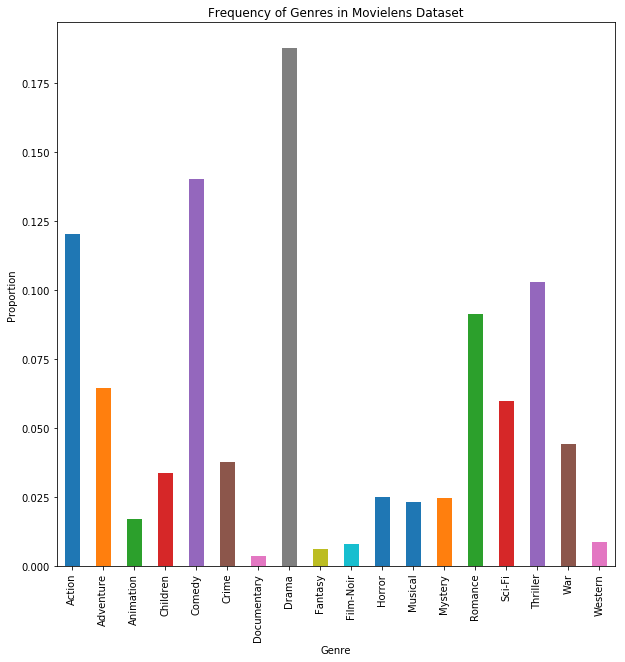

In [29]:
### BEGIN CODE ###
movie_column_labels = all_data.columns[9:27]

movie_genres = all_data[movie_column_labels]
genre_count = movie_genres.sum()
genre_count_sum = sum(genre_count)
genre_frequency = genre_count / genre_count_sum
### END CODE ###

plt.figure(figsize=(10, 10));
plt.title("Frequency of Genres in Movielens Dataset");
plt.xlabel("Genre");
plt.ylabel("Proportion");
genre_frequency.plot.bar();

<hr>

**2.2:** It is important to identify biases in our dataset that can skew our results or impact how generalizable our recommendation system is to novel users and novel movies. What might be some issues we run into by using this dataset?

<b>Answer:</b> From the plot, we see that the different genres are not equally represented: We have a high proportion of Drama, Comedy, Action, Thriller, and Romance films, while in contrast, we have very low representation for Documentary, Fantasy, Film-Noir, and Western Movies. This could present a problem if we want to make recommendations for users who like the less-represented films, as that means there is less data to work with.

<hr>

**2.2:** Distribution of User Ratings

Plot the distribution of user ratings for movies from the Children, Fantasy, and Film-Noir genres -- that is, for each genre, plot a distribution describing the number of ratings from 1 to 5 received by movies belonging to that genre. Note any similarities or differences between your plots -- how does this inform us about biases in the dataset, and how could such bias affect our predictions?

*[Hint: Try multiple histograms or bar plots]*

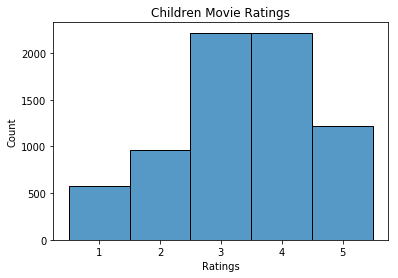

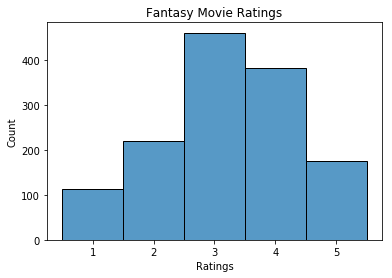

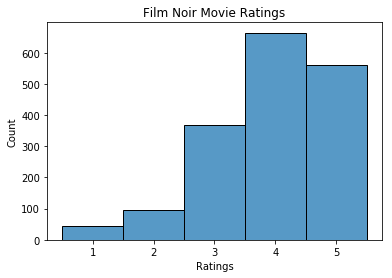

In [6]:
### BEGIN CODE ###
children_ratings = all_data[all_data["Children"] == 1]['rating'].astype('str').sort_values()
fantasy_ratings = all_data[all_data["Fantasy"] == 1]['rating'].astype('str').sort_values()
film_noir_ratings = all_data[all_data["Film-Noir"] == 1]['rating'].astype('str').sort_values()
### END CODE ###

### BEGIN PLOTTING ###
sns.histplot(data=children_ratings, label="Children")
plt.title("Children Movie Ratings")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.show()

sns.histplot(data=fantasy_ratings, label="Fantasy")
plt.title("Fantasy Movie Ratings")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.show()

sns.histplot(data=film_noir_ratings, label="Film Noir")
plt.title("Film Noir Movie Ratings")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.show()
### END PLOTTING ###

<b>Answer:</b> All three distributions follow a roughly normal distribution with a center or average between 3 and 4. All genres seem to have slight left skew, which reflects that most users rated movies more positively than negatively.

The first approach we will investigate is the "Cluster-Based" Approach. We first define the following matrix known as the "user-item interaction matrix", where each row represents a user's ratings and each column represent's the ratings for a movie. In other words, $A_{ij}$ represents user $i$'s rating of movie $j$.

<hr>

# Question 3: The User-Interaction Matrix

<hr>

**3.1:** How many unique users and unique movies are there in our dataset? Assign your answers to `num_users` and `num_movies`, respectively.

*Hint: What data structure did you also see this week in CS 61B could be helpful here?*

In [31]:
# Answer to Hint: In Week 6 of CS 61B, Students will be introduced to the idea of Sets. Sets have a special property
# where they do not contain duplicates by construction. This means sets can implicitly remove duplicate entries
# and return just the unique users and movies in our DataFrame.

### BEGIN CODE ###
unique_users = set(all_data["user_id"])
unique_movies = set(all_data["movie_id"])
num_users = len(unique_users)
num_movies = len(unique_movies)
### END CODE ###

print("Number of ratings:", len(all_data))
print("Number of unique users:", num_users)
print("Number of unique movies:", num_movies)

Number of ratings: 100000
Number of unique users: 943
Number of unique movies: 1682


<hr>

**3.2:** You should see that the values for the number of unique users and unique movies are much smaller than the dimensions of our raw data matrix. What does that tell us about how many movies each user rated? What is the most common number in our raw data matrix?

<b>Answer:</b> We have far fewer unique users and unique movies than the number of ratings in the total dataset. This tells us two things: one, that each user rates many different movies, and two, our matrix is actually very "sparse," which we define as a matrix or vector where many of the values are 0.

<hr>

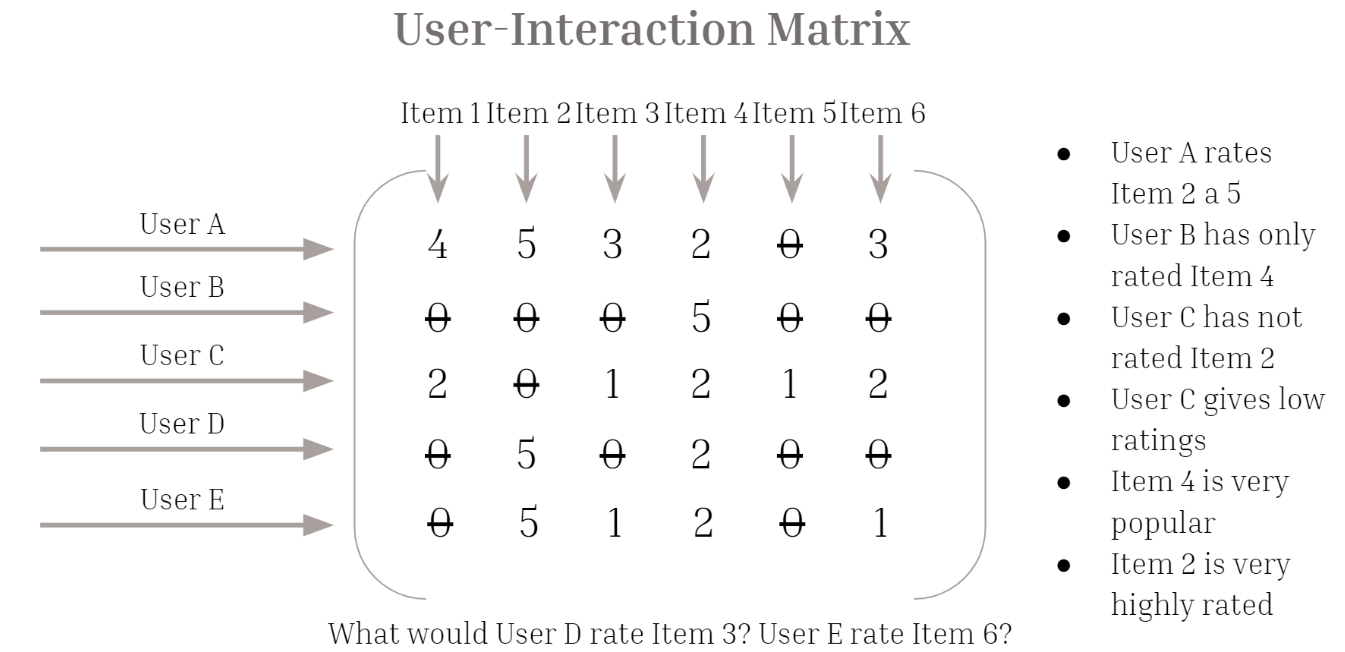

**3.3:** Construct the User-Item Interaction Matrix above taken from this week's slides. Call it `interaction_matrix.` Print out its dimensions and the first few rows. Confirm that the dimensions match with the number of unique users and movies you found in **3.1**.

*Hint: Look into the Pandas function `df.pivot` (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html)*

In [40]:
### BEGIN CODE ###
truncated_data = ratings[["user_id", "movie_id", "rating"]]
interaction_matrix = truncated_data.pivot(index="user_id", columns="movie_id", values="rating").fillna(0);
### END CODE ###

print("Interaction Matrix Dimensions: ", interaction_matrix.shape);
display(interaction_matrix.head());

Interaction Matrix Dimensions:  (943, 1682)


movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


You should see that most of the values in the matrix are 0. This reflects the fact that the original `all_data` matrix was sparse.

<hr>

# Question 4: Cosine Similarity

One accessible way to perform collaborative filtering is through a method known as "cosine similarity". It boils down to the following:

* Treat each user row or movie column as a vector
* Determine the cosine of the angle between every pair of vectors

This can be expressed with the following expression: For vectors $i$ and $j$ of length $n$, their similarity is calculated as:
$$cos(\theta) = \frac{v_i v_j}{|v_i||v_j|} = \sum_{k=1}^{n}\frac{v_{i,k} v_{j,k}}{\sqrt{\sum_{k=1}^{n}v_{i,k}^2} \sqrt{\sum_{k=1}^{n}v_{j,k}^2}}$$

**4.1:** Fill out the following function `cosine_similarity(U, V)` to compute the cosine similarity of the vectors in a matrix:

Note: You can use `np.finfo(float).eps` to add a "fudge" factor and prevent issues with ratings of 0.

In [33]:
def cosine_similarity(U):
    '''
    Inputs:
        - U: Data of interest represented as vectors in a matrix
    Output:
        - similarity: Matrix where a_{i,j} represents the cosine similarity betwee vectors v_i and v_j
    '''
    ### BEGIN CODE ###
    numerator = U @ U.T + np.finfo(float).eps
    root_norm = np.array([np.sqrt(np.diagonal(numerator))])
    similarity = numerator / (root_norm * root_norm.T)
    ### END CODE ###
    
    return similarity

**4.2:** Use the completed function to find the cosine similarity between users. Assign this to `user_similarity`.

Hint: Treat each row of `interaction_matrix` as a vector.

In [34]:
### BEGIN CODE ###
user_similarity = cosine_similarity(interaction_matrix)
### END CODE ###

user_similarity.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.166931,0.047460,0.064358,0.378475,0.430239,0.440367,0.319072,0.078138,0.376544,...,0.369527,0.119482,0.274876,0.189705,0.197326,0.118095,0.314072,0.148617,0.179508,0.398175
2,0.166931,1.000000,0.110591,0.178121,0.072979,0.245843,0.107328,0.103344,0.161048,0.159862,...,0.156986,0.307942,0.358789,0.424046,0.319889,0.228583,0.226790,0.161485,0.172268,0.105798
3,0.047460,0.110591,1.000000,0.344151,0.021245,0.072415,0.066137,0.083060,0.061040,0.065151,...,0.031875,0.042753,0.163829,0.069038,0.124245,0.026271,0.161890,0.101243,0.133416,0.026556
4,0.064358,0.178121,0.344151,1.000000,0.031804,0.068044,0.091230,0.188060,0.101284,0.060859,...,0.052107,0.036784,0.133115,0.193471,0.146058,0.030138,0.196858,0.152041,0.170086,0.058752
5,0.378475,0.072979,0.021245,0.031804,1.000000,0.237286,0.373600,0.248930,0.056847,0.201427,...,0.338794,0.080580,0.094924,0.079779,0.148607,0.071459,0.239955,0.139595,0.152497,0.313941


**4.3:** What does each value in the matrix represent? Why is the diagonal $\mathbb{1}_m$, i.e., why are there 1's along the diagonal?

<b>Answer:</b> Each value in the matrix represents the "similarity" between two users as measured by the cosine similarity of their ratings represented as high-dimensional, sparse vectors. We see 1's along the diagonal, which makes sense, since that diagonal computes the similarity of each user with themselves.

 **4.4:** How could we now use this matrix to recommend movies to a user? What drawbacks are there with using this approach?

<b>Answer:</b> We can recommend movies for a particular user in `user_similarity` by looking at the next highest values in each user's row. The highest values represent the most similar users, meaning the movies they rated highly are likely movies this particular user would also rate highly.

one drawback is that this only works for the users in our database. In other words, this `user_similarity` matrix must be recomputed each time a user rates a new movie or each time a new user uses our service. This algorithmic complexity can by shortened by only computing a new vector for the new user and recomputing the vector for the movies they've rated, but this is not as clean of a process as with the clustering approach we saw earlier.

**4.5:** How can we change the input to `cosine_similarity` to compute the cosine similarity between movies, rather than users?

<b>Answer:</b> We can swap the order of matrix multiplication. In other words, if $A = interaction\_matrix$, we use $A^TA$ instead of $AA^T$, and we instead run this line of code: `cosine_similarity(interaction_matrix.T)`. Now, Each value in the matrix represents the similarity between two movies as measured by the cosine similarity of their ratings represented as high-dimensional, sparse vectors.

These two approaches are also known by other names: When we recommend similar users based on the ratings they give, that is called **user-user collaborative filtering**. Alternatively, when we look for similar items based on the ratings given to them by users, that is called **item-item collaborative filtering**.

<hr>

# Question 5: Memory-Based Approaches and Clustering

<hr>
The simplest way to make a recommendation using this matrix is by grouping together users who are most similar to one another. In this way, we create groups, or clusters, that represent users who give similar ratings. This boils down to the algorithm known as K-Nearest Neighbors (KNN), which is used to partition data into K clusters of greatest similarity. This is spiritually similar to the K-Means Clustering you saw in lecture earlier this week -- K-Means Clustering is an unsupervised learning technique that assigns the data into $K$ clusters, while KNN looks at the $K$ data points most similar to a certain training point in order to assign it a class or label.

For the purposes of this assignment, we will look at a pre-imlemented [KNN Algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors) from [scikit-learn](https://scikit-learn.org/), the machine learning library we have been working with over the last few weeks of 16ML. The KNN Algorithm we use here is a bit simpler than what KNN truely should be, because instead of assigning labels based on the $K$ nearest neighbors, we will use this to simply identify the $K$ nearest neighbors.

[Note: Later on in EECS 16B, you will revisit K-Means Clustering. This will be used in lab to classify voice commands to control your car.]

<hr>

**3.4:** Read the linked documentation to understand how to use the KNN Algorithm from Scikit-Learn. What are the relevant functions and return values we can use?

<b>Answer:</b> We can import this Algorithm with the following line of code: `from sklearn.neighbors import NearestNeighbors`. The Algorithm is treated as a class with various methods. Next, we instantiate the Algorithm class with `nn = NearestNeighbors(n_neighbors=x)`. We can then use the `fit(X)` function to run the KNN algorithm on our `interaction_matrix`. 

Another useful function is `kneighbors`, which will return a `distance` matrix representing the distance from each vector to every other vector, and an `indcies` matrix containing the $k$ nearest neighbors i.e. vectors for each given vector.

**3.5:** Run KNN on `interaction_matrix` from the earlier part of this question. For now, use k = 10.

In [36]:
### BEGIN CODE ###
from sklearn.neighbors import NearestNeighbors
model = NearestNeighbors(n_neighbors=10)
model.fit(interaction_matrix)

distances, indices = model.kneighbors(interaction_matrix)
indices += 1
### END CODE ###

print("Shape of distances matrix:", distances.shape)
display(distances)
print("Shape of indices matrix:", indices.shape)
display(indices)

Shape of distances matrix: (943, 10)


array([[ 0.        , 55.06359959, 55.23585792, ..., 57.51521538,
        57.61076288, 57.62811814],
       [ 0.        , 25.63201124, 28.01785145, ..., 28.37252192,
        28.54820485, 28.65309756],
       [ 0.        , 20.95232684, 21.3541565 , ..., 22.09072203,
        22.20360331, 22.22611077],
       ...,
       [ 0.        , 20.71231518, 20.76053949, ..., 21.26029163,
        21.33072901, 21.3541565 ],
       [ 0.        , 37.16180835, 37.52332608, ..., 38.28837944,
        38.37968212, 38.39270764],
       [ 0.        , 43.35896678, 43.8634244 , ..., 45.22167622,
        45.2437841 , 45.40925016]])

Shape of indices matrix: (943, 10)


array([[  1, 738, 521, ..., 773, 215, 774],
       [  2, 701, 266, ..., 520, 651, 111],
       [  3, 317, 656, ..., 685,  61, 809],
       ...,
       [941, 742, 441, ...,  17, 578, 609],
       [942, 163, 856, ..., 205, 202, 656],
       [943, 933, 774, ..., 778, 175, 538]], dtype=int64)

<hr>

**3.5:** Let's look at the first user in our `interaction_matrix`. What other users is our user most similar to? What are the IDs of the movies these users liked?

In [35]:
### BEGIN CODE ###
first_user = indices[0]
similar_users = (interaction_matrix.loc[first_user])
### END CODE ###

display(first_user)
display(similar_users)

array([  1, 738, 521, 933, 715,  44, 868, 773, 215, 774], dtype=int64)

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
738,5.0,3.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
521,2.0,3.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
933,3.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
715,5.0,3.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,4.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
868,4.0,2.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
773,3.0,3.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<hr>

# Question 6: Model-Based Approaches -- Matrix Factorization and Embeddings

There are a few issues with the cluster-based approach in Question 3. The biggest issue is that this casts the data in terms of the users we have data for. In other words, we are taking a 'User-User Approach' that is highly reliant on similar data or ratings between users in order to form reliable or accurate clusters. In reality, our interaction matrix is very sparse, meaning that many of the entries or values in it are 0. This means that it may be hard to identify similarity between users, and any slight changes will alter our recommendations.

Another approach we can use is known as an 'item-item approach' that instead leverages matrix factorization to break apart matrices into other matrices or vectors that have special meanings or interpretations.

<hr>

**5.1:** What Matrix Decompositions you have seen in EECS 16A and EECS 16B? What are the tradeoffs or different use cases for one over the other?

<b>Answer:</b> We have seen Diagonalization, aka Eigenvalue Decomposition, in EECS 16A, and have heard of the SVD from earlier weeks of 16ML / references in EECS 16B. Both factorization methods break a matrix apart into three matrices: either $P\Lambda P^T$ for Diagonalization, or $U\Sigma V^T$ the SVD. We should use the SVD because it generalizes Diagonalization to the non-square matrix we are working with. Further, SVD has a natural connection to dimensionality reduction and clustering, making it a great tool for factoring our matrix and understanding its components.

<hr>

Here is a quick refresher on the SVD:

For a matrix $A \in \mathbb{R}^{mxn}$, the "Full SVD" is the following matrix product:
$$A = U\Sigma V^T$$
where
$$U \in \mathbb{R}^{}$$
$$\Sigma \in \mathbb{R}^{}$$
$$V^T \in \mathbb{R}^{}$$

Alternatively, there is a "Compact SVD" that involves truncating these matrices to remove zero-value singular vectors corresponding to the Nullspace of $A$:

$$A = U_c\Sigma_c V_c^T$$
where
$$U_c \in \mathbb{R}^{}$$
$$\Sigma_c \in \mathbb{R}^{}$$
$$V_c^T \in \mathbb{R}^{}$$

As popularized during the 2006 Netflix Prize, there is a famed "SVD" Matrix Factorization Algorithm used for creating a recommendation system. NOTE: THIS IS A DIFFERENT SVD! Even though they are both called "SVD", and are spiritually related in the sense that they are both related to matrix decomposition/factorization, they are in fact, different algorithms/procedures entirely. They are related in the sense that after the following procedure, the resulting matrix $A$ should converge to the SVD.

<hr>

Our goal will be to factorize `interaction_matrix` and approximate it as the product $A = UV^T$. For a matrix $A \in \mathbb{R}^{m x n}$, it will be equal to the product $U \in \mathbb{R}^{m x d}$ and $V^T \in \mathbb{R}^{d x n}$.

In the literature, U is referred to as the User Embeddings, while V is referred to as the Movie Embeddings. Each row of U, represented by $U_i$, denotes the "essence" of user $i$, while each row of $V$ i.e. each column of $V^T$, represented by $V_j$, denotes the "essence" of movie $j$.

**5.2:** How can we approximate the matrix A using a sum instead of a matrix product?

<b>Answer:</b> We already have `interaction_matrix`, where the rows represent each user's ratings for the movies in the dataset, while each column represents all of the ratings a single movie received. So, we can iterate over these vectors to calculate the following:

$$A^*_{i,j} = \vec{u_i}^T\vec{v_j}$$

**5.3:** Why can't we simply ues the row and column vectors in `interaction_matrix` to compute this?

<b>Answer:</b> $u_i$ and $v_j$ are embeddings that represent the abstract meaning or value of each user or movie. This is spiritually similar to how the singular vectors in the SVD are different from the rows and columns in the original matrix $A$.

**5.4:** Calculate $A^*$, the approximation for $A$, using gradient descent with randomly-initialized embedded vectors for $U$ and $V$.

In [38]:
### BEGIN CODE ###
U = np.random.normal(size=[interaction_matrix.shape[0], 5])
V = np.random.normal(size=[interaction_matrix.shape[1], 5])
### END CODE ###

In [37]:
gamma = 0.1

### BEGIN CODE ###

# for u in range(len(U)):
#     for v in range(len(V)):
for u in range(50):
    for v in range(50):
        for _ in range(100):
            pred = np.dot(U[u], V[v])
            actual = interaction_matrix.iloc[u, v]
            error = pred - actual
            U[u] = U[u] + gamma * error
            V[v] = V[v] + gamma * error
            
### END CODE ###

NameError: name 'U' is not defined

In [ ]:
A_star = np.dot(U, V.T)

<hr> 

# Q7: Making Your Own Predictions

<hr> 

# Summary and Extensions

Congratulations! We've reached the end of the assignment. We hope that this was an eye-opening experience into a very applied topic of interest in machine learning. To summarize what we've covered so far:
* History of Recommender Systems and the Netflix Prize
* Loading Datasets
* Exploratory Data Analysis
* User-Interaction Matrices
* Cosine Similarity
* Memory-Based Approaches
    * Sparse, High-Dimensional Vectors
    * Clustering, KNN, and K-Means
* Model-Based Approaches
    * User and Movie Embeddings
    * Gradient Descent and SGD
* Making your own Predictions

If you are interested in further investigating collaborative filtering algorithms and building recommender systems, here are some relevant links to sophisticated packages used in production settings, cutting-edge improvements, and current, unsolved issues:

<hr>

### Surpriselib

Surprise is a Package for SciPy. It is a dedicated SciPy package for building and analyzing Recommender Systems. In particular, it has native access to various datasets such as MovieLens, and also has a wide array of prediction algorithms.

* [SurpriseLib Website](http://surpriselib.com/)
* [GitHub Link](https://github.com/NicolasHug/Surprise)

Here is a demo for using Surprise to perform prediction using cosine similarity and KNN:

In [ ]:
!pip install scikit-surprise

In [ ]:
from surprise import Dataset
from surprise import Reader
from surprise import KNNWithMeans

surprise_ratings = {
    "item": [1, 2,
             1, 2,
             1, 2,
             1, 2,
             1],
    "user": ['A', 'A',
             'B', 'B',
             'C', 'C',
             'D', 'D',
             'E'],
    "rating": [1, 2,
               2, 4,
               2.5, 4,
               4.5, 5,
               3],
}

reader = Reader(rating_scale=(1, 5))
df = pd.DataFrame(surprise_ratings)
display(df)

# Load ratings into form that Surpriselib can use
surprise_data = Dataset.load_from_df(df[["user", "item", "rating"]], reader)

# item-based cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": False,  # Flag to determine whether to do user-user or item-item similarity
}
surprise_algorithm = KNNWithMeans(sim_options=sim_options)
surprise_training_data = surprise_data.build_full_trainset()

surprise_algorithm.fit(surprise_training_data)

surprise_prediction = algo.predict('E', 2)
print(surprise_prediction.est)

<hr>

### Alternative and Advanced Methods

**Deep Learning and Deep Neural Networks**

Later on in 16ML, we will introduce the idea of Deep Learning, which relies heavily on using Neural Networks with many, many layers to perform complex computations. These are considered state-of-the-art models that are at the forefront of recent advances in many different fields of Machine Learning, and are a valid option for developing a recommender system.

**Regularization**

When performing Model-Based Collaborative Filtering, we can run into the issue of underregularization. This is a concept that was discussed earlier in 16ML during Week 4. In essence, regularization allows us to "smooth" out our data by "lifting" up small, near-zero values in our data that can cause numerical instability and/or unexpected magnification of small values. Regularization can help with Collaborative Filtering by dealing with movies that were not rated by many users, or users who did not rate many movies. In this way, it can help reduce error in predicting or recommending new movies to users, or conversely, identifying new users who might like a given movie.

<hr>

### Issues

**Cold Start**

A fundamental flaw with recommender systems as they currently exist is a concept called "Cold Start." Consider the following: we've been working with a massive matrix containing ratings given by various users to various movies. What happens when we add a new movie to the database? Any new movies will have no ratings from any user, meaning that our collaborative filtering algorithms have no information whatsoever on how a user will like it. That means that these movies will never be recommended with an naive algorithm. This means that we must carefully consider how we add new movies to our database. Some considerations include assigning it the same user ratings as a movie we believe to be very similar, or perhaps using some metric such as median or average to get a representative value of the new movie's genre.

As we saw earlier, the matrices we are working with are very sparse, which will also inherently contribute to the Cold Start problem.

<hr>

# References

* The Netflix Prize. https://en.wikipedia.org/wiki/Netflix_Prize
* Baptiste Rocca. Introduction to recommender systems. https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada,2019.
* Simon Funk. Netflix update:Try this at home. https://sifter.org/simon/journal/20061211.html, 2006.
* Yehuda Koren. The bellkor solution to the netflix grand prize. Published on Netflix PrizeForums, 2009.
* Build a Recommendation Engine With Collaborative Filtering. https://realpython.com/build-recommendation-engine-collaborative-filtering/
* Prince Grover. Various Implementations of Collaborative Filtering https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0
* Intro to Recommender Systems: Collaborative Filtering https://www.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/
* Alesha Tony. All You Need to Know About Collaborative Filtering https://www.digitalvidya.com/blog/collaborative-filtering/
* MovieLens Dataset https://grouplens.org/datasets/movielens/
* Surprise: A Python scikit for recommender systems. http://surpriselib.com/
* Movies Recommender System with Surpriselib. https://medium.com/analytics-vidhya/movies-recommender-system-with-surpriselib-33580ae9b47c